# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
import imageio
#from scipy.misc.pilutil import imread,imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import skimage.transform

In [ ]:
!pip install scipy==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scipy-1.2.0-cp37-cp37m-manylinux1_x86_64.whl (26.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 4.1.4 requires scipy>=1.4.1, but you have scipy 1.2.0 which is incompatible.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.2.0 which is incompatible.
jaxlib 0.3.22+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.2.0 which is incompatible.
jax 0.3.23 requires scipy>=1.5, but you have scipy 1.2.0 which is incompatible.
aeppl 0.0.33 requires scipy>=1.4.0, but you have scipy 1.2.0 which is incompatible.


We set the random seed so that the results don't vary drastically.

In [ ]:
# np.random.seed(30)
# import random as rn
# rn.seed(30)
# from keras import backend as K
# import tensorflow as tf
# tf.random.set_seed(30)


# import os
# os.environ['PYTHONHASHSEED']="30"
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)
from keras import backend as K

In [ ]:
!pip install jax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.2.0
    Uninstalling scipy-1.2.0:
      Successfully uninstalled scipy-1.2.0


In [ ]:
# mount google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip  -o "/content/gdrive/MyDrive/CNN/Project_data.zip" -d "/content/gdrive/MyDrive/CNN/"

Streaming output truncated to the last 5000 lines.
 extracting: /content/gdrive/MyDrive/CNN/Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00029.png  
 extracting: /content/gdrive/MyDrive/CNN/Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00031.png  
 extracting: /content/gdrive/MyDrive/CNN/Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00033.png  
 extracting: /content/gdrive/MyDrive/CNN/Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00035.png  
 extracting: /content/gdrive/MyDrive/CNN/Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00037.png  
 extracting: /content/gdrive/MyDrive/CNN/Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00039.png  
 extracting: /content/gdrive/MyDrive/CNN/Project_data/train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_201

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/CNN/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/CNN/Project_data/val.csv').readlines())
batch_size = 32
seq_idx = range(7,26,2)
dim_x, dim_y = 120, 120




## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size,debug=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        t = np.random.permutation(folder_list)
        if (len(t)%batch_size) == 0: # remaining seq
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = skimage.transform.resize(image, (y,z))

                   
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] =resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] =resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =resized_im[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/CNN/Project_data/train'
val_path = '/content/gdrive/MyDrive/CNN/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [ ]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Source path =  /content/gdrive/MyDrive/CNN/Project_data/train ; batch size = 1


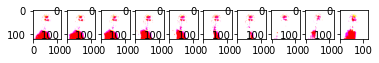

In [ ]:
test_gen = generator(train_path, train_doc, 1,debug=True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)
#write your model here

In [ ]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = optimizers.Adam(lr=0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 118, 118, 32)   2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 59, 59, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/gdrive/MyDrive/CNN/Project_data/train ; batch size = 32
Epoch 1/50
20/21 [===========================>..] - ETA: 24s - loss: 12.4048 - categorical_accuracy: 0.1953

UnknownError: ignored